In [1]:
import re
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

results_dir = Path("results")

In [5]:
SYSTEM_SIZE = 16
ATOL_H = 1e-3

TARGET_SEEDS = {42, 43, 44} # make range since we do overlap anyways later


all_files = list(results_dir.glob(f"tfim_{SYSTEM_SIZE}_entangle_rbm_seed*_*.csv"))
parsed = []

for p in all_files:
    s_match = re.search(r"seed(\d+)", p.name)
    t_match = re.search(r"(\d{8}_\d{6})", p.name)
    if s_match and t_match:
        parsed.append({"seed": int(s_match.group(1)), "ts": t_match.group(1), "path": p})

parsed.sort(key=lambda x: x["ts"], reverse=True)

selected_map = {}
for item in parsed:
    s = item["seed"]
    if s in TARGET_SEEDS and s not in selected_map:
        selected_map[s] = item["path"]

selected_paths = [selected_map[s] for s in sorted(selected_map.keys())]

print(f"Found {len(selected_paths)} result files overlapping with specified seed set (newest match only):")
for p in selected_paths:
    print(f"  - {p.name}")

Found 3 result files overlapping with specified seed set (newest match only):
  - tfim_16_entangle_rbm_seed42_20260205_212253.csv
  - tfim_16_entangle_rbm_seed43_20260205_212254.csv
  - tfim_16_entangle_rbm_seed44_20260205_212251.csv


In [8]:
dfs = [pd.read_csv(p) for p in selected_paths]
all_results_df = pd.concat(dfs, ignore_index=True)

# keep only columns we use
all_results_df = all_results_df[["seed", "h", "l", "type", "s2"]].copy()

# ensure numeric
all_results_df["seed"] = all_results_df["seed"].astype(int)
all_results_df["h"] = all_results_df["h"].astype(float)
all_results_df["l"] = all_results_df["l"].astype(int)
all_results_df["s2"] = all_results_df["s2"].astype(float)

print(f"\nSeeds: {sorted(all_results_df['seed'].unique())}")
print(f"Types: {sorted(all_results_df['type'].unique())}")


Seeds: [42, 43, 44]
Types: ['novel', 'support']


In [9]:
agg_df = (
    all_results_df
    .groupby(["type", "h", "l"], as_index=False, observed=True)
    .agg(
        s2=("s2", "median"),
        s2_err=("s2", lambda x: x.std(ddof=0)),
        n=("s2", "count"),
    )
    .sort_values(["h", "l"])
)
agg_df.head()

,type,h,l,s2,s2_err,n
112,support,0.5,1,0.622282,0.007695,3
113,support,0.5,2,0.682527,0.000641,3
114,support,0.5,3,0.690113,0.001685,3
115,support,0.5,4,0.691430,0.002300,3
116,support,0.5,5,0.691489,0.002347,3


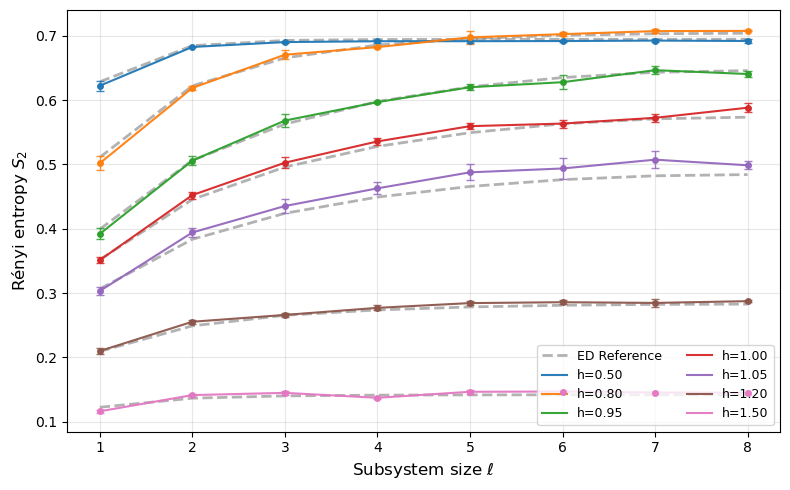

In [12]:
# --- Aggregated mean ± err (support only) ---

plot_df = agg_df[agg_df["type"] == "support"].copy()
h_support_vals = sorted(plot_df["h"].unique())

# reference
ref_file = Path(f"tfim_{SYSTEM_SIZE}_entangle_ref.csv")
ref_df = pd.read_csv(ref_file) if ref_file.exists() else None

def overlay_ed(ax):
    if ref_df is None or not {"h", "l", "s2"}.issubset(ref_df.columns):
        return False

    added = False
    for h in h_support_vals:
        sub = ref_df[np.isclose(ref_df["h"], h, atol=ATOL_H)].sort_values("l")
        if sub.empty:
            continue
        ax.plot(
            sub["l"], sub["s2"],
            "--", color="gray", linewidth=2, alpha=0.6, zorder=0,
            label=("ED Reference" if not added else None),
        )
        added = True
    return added

fig, ax = plt.subplots(figsize=(8, 5), dpi=100)
cmap = plt.get_cmap("tab10")

overlay_ed(ax)

# make the line more opaque
alpha_line = 0.95
alpha_marker = 0.95
alpha_err = 0.85

for j, h in enumerate(h_support_vals):
    color = cmap(j % 10)
    sub = plot_df[np.isclose(plot_df["h"], h, atol=ATOL_H)].sort_values("l")

    x = sub["l"].to_numpy(dtype=float)
    y = sub["s2"].to_numpy(dtype=float)
    yerr = sub["s2_err"].to_numpy(dtype=float)

    # error bars only (keeps line opacity independent)
    ax.errorbar(
        x, y, yerr=yerr,
        fmt="none", ecolor=color, elinewidth=1.0, capsize=3,
        alpha=alpha_err, zorder=4
    )

    # line + markers
    ax.plot(x, y, "-", color=color, linewidth=1.5, alpha=alpha_line, zorder=5, label=f"h={h:.2f}")
    ax.plot(x, y, "o", color=color, markersize=4, alpha=alpha_marker, zorder=6)

ax.set_xlabel(r"Subsystem size $\ell$", fontsize=12)
ax.set_ylabel(r"Rényi entropy $S_2$", fontsize=12)
ax.grid(True, alpha=0.3)
ax.legend(loc="lower right", ncol=2, fontsize=9)
fig.tight_layout()
plt.show()

In [13]:
# Save aggregated CSV back to results/ (no prompt / no row printing)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
save_path = results_dir / f"tfim_{SYSTEM_SIZE}_entangle_rbm_err_{timestamp}.csv"

out_df = agg_df[["h", "l", "type", "s2", "s2_err"]].copy()
out_df.to_csv(save_path, index=False, float_format="%.6e")

print(f"Saved: {save_path}")

Saved: results/tfim_16_entangle_rbm_err_20260206_011638.csv
